In [1]:
import zerosum as zs
from zerosum.algorithms.thompson import BetaThompson, LinearBetaThompson

Thompson Sampling for Rock Paper Scissors.

In [2]:
from zerosum.rps.game import RPS


algo = BetaThompson((-1, 1))

for _ in range(1000):
    algo.once(RPS())

In [3]:
algo.priors

{InfoSet(player=0): {<Action.ROCK: 0>: (153.5, 182.5),
  <Action.PAPER: 1>: (160.0, 184.0),
  <Action.SCISSORS: 2>: (158.0, 168.0)},
 InfoSet(player=1): {<Action.ROCK: 0>: (187.0, 190.0),
  <Action.PAPER: 1>: (148.5, 146.5),
  <Action.SCISSORS: 2>: (163.5, 170.5)}}

It seems to work just as well with Kuhn poker.

In [4]:
from zerosum.kuhn.game import Kuhn

In [5]:
algo = BetaThompson((-2, 2))

for _ in range(30000):
    algo.once(Kuhn())

In [6]:
algo.priors

{InfoSet(player=0, card=3, history=()): {<Action.CHECK: 5>: (4219.75, 1090.25),
  <Action.BET: 4>: (3567.5, 913.5),
  <Action.FOLD: 7>: (3.5, 8.5)},
 InfoSet(player=1, card=2, history=(<Action.BET: 4>,)): {<Action.CALL: 6>: (258.0,
   834.0),
  <Action.FOLD: 7>: (453.5, 1358.5)},
 InfoSet(player=0, card=2, history=()): {<Action.CHECK: 5>: (3669.5, 5138.5),
  <Action.BET: 4>: (444.5, 715.5),
  <Action.FOLD: 7>: (18.25, 52.75)},
 InfoSet(player=1, card=1, history=(<Action.BET: 4>,)): {<Action.CALL: 6>: (1.0,
   22.0),
  <Action.FOLD: 7>: (721.0, 2161.0)},
 InfoSet(player=1, card=3, history=(<Action.BET: 4>,)): {<Action.CALL: 6>: (1225.0,
   1.0),
  <Action.FOLD: 7>: (1.5, 2.5)},
 InfoSet(player=1, card=3, history=(<Action.CHECK: 5>,)): {<Action.BET: 4>: (4969.0,
   972.0),
  <Action.CHECK: 5>: (110.5, 37.5)},
 InfoSet(player=1, card=1, history=(<Action.CHECK: 5>,)): {<Action.BET: 4>: (577.0,
   1800.0),
  <Action.CHECK: 5>: (1186.0, 3556.0)},
 InfoSet(player=0, card=1, history=()): {<Act

In [7]:
%cd ..

/Users/belart/code/pkr/cfr


In [44]:
from blood.h8a20d30p import TrainingAbstraction

algo = LinearBetaThompson((-400, 400), 1_000_000)

In [212]:
try:
    for _ in range(10000):
        for _ in range(100):
            algo.once(TrainingAbstraction())

        print(f"{len(algo.priors)}\t{algo.touched}\t", end="\r")
except KeyboardInterrupt:
    pass

In [213]:
g = TrainingAbstraction()

g = g.apply(g.sample())
g = g.apply(g.sample())

infoset = g.infoset(g.active)
print(g)
algo.priors[infoset]

TrainingAbstraction(history=(Draw(hand=(30, 7)), Draw(hand=(40, 39))), community=(), active=0, stacks=(400, 400), pips=(1, 2), pot=0)


{Fold(): (17.441250000000007, 17.448750000000008),
 Call(): (9.955000000000005, 9.955000000000002),
 RaisePot(): (14.396818181818174, 14.396818181818174),
 Allin(): (8.302045454545452, 7.297045454545453)}

In [216]:
from zerosum.pkr.game import Draw, Fold, Call, RaisePot, Allin

from collections import defaultdict
from tqdm import tqdm
import numpy as np


table = defaultdict(list)

for i in tqdm(range(52)):
    for j in range(i + 1, 52):
        if i == j:
            continue

        ri, si = divmod(i, 4)
        rj, sj = divmod(j, 4)

        g = TrainingAbstraction().apply(Draw((i, j))).apply(Draw((i, j)))
        infoset = g.infoset(g.active)
        try:
            s = algo.priors[infoset]
        except KeyError:
            continue

        l, r = 12 - min(ri, rj), 12 - max(ri, rj)
        if si == sj:
            ix = r, l
        else:
            ix = l, r

        action = max(s, key=lambda a: s[a][0] / sum(s[a]))
        would = isinstance(action, (Fold,))
        table[ix].append(1 if would else 0)

100%|██████████| 52/52 [00:00<00:00, 56.00it/s]


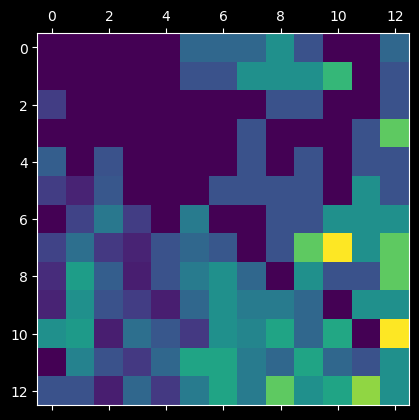

In [217]:
tab = np.zeros((13, 13))
for (i, j), v in table.items():
    tab[i, j] = np.mean(v)

import matplotlib.pyplot as plt
plt.matshow(tab, vmin=0, vmax=1)

In [157]:
len(algo.priors)

31549

In [160]:
s = {}
for iset, priors in tqdm(algo.priors.items()):
    s[iset] = {a: p[0] / sum(p) for a, p in priors.items()}

100%|██████████| 31549/31549 [00:19<00:00, 1583.85it/s]


In [191]:
def play(game, strategies):
    while not game.terminal:
        if game.chance:
            action = game.sample()
        else:
            infoset = game.infoset(game.active)
            actions = infoset.actions()

            if infoset in strategies:
                action = max(actions, key=strategies[infoset].__getitem__)
            else:
                actions = infoset.actions()
                action = np.random.choice(actions)
                print("unknown")

        yield action
        game = game.apply(action)

In [201]:
from zerosum.game import play

list(play(TrainingAbstraction(), s))

[Draw(hand=(35, 39)),
 Draw(hand=(25, 38)),
 Allin(),
 Call(),
 Flop(cards=(50, 8, 18)),
 Check(),
 Check(),
 Turn(cards=(29,)),
 Check(),
 Check(),
 River(cards=(23,)),
 Check(),
 Check()]